In [46]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
homedir = os.path.expanduser('~')

In [2]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCH*_1f.spec.fits'))

fluxes = []
wls = []
am = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    airmass = (hdr["AMSTART"] + hdr["AMEND"])/2
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    #print(wl.shape)
    
    fluxes.append(flux)
    wls.append(wl)
    am.append(airmass)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
#ind = np.where(np.isinf(wfobs0)) # set infinite values in noise spectrum to NaNs
#wfobs0[ind] = np.nan
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [8]:
# check if wl changes across orders
jj=1
pix=0
wls[0,:,pix]

array([1.79291584, 1.77544383, 1.75832308, 1.74154324, 1.72509441,
       1.70896703, 1.69315192, 1.67764024, 1.66242349, 1.64749347,
       1.63284231, 1.61846238, 1.60434638, 1.59048722, 1.5768781 ,
       1.56351243, 1.55038386, 1.53748626, 1.52481373, 1.51236052,
       1.50012112, 1.48809018, 1.47626254])

#### Load H band results

In [47]:
chipmods = fits.getdata("result/IGRINS_W1049B_H_chipmods_lte015.0-5.0.fits")
chiplams = fits.getdata("result/IGRINS_W1049B_H_chiplams_lte015.0-5.0.fits")
results = Table.read('result/IGRINS_W1049B_H_fitting_results_lte015.0-5.0.txt', format='ascii')
results

order,obs,chisq,vsini,limbdark,rv
int64,int64,float64,float64,float64,float64
0,0,23064.41293939637,44.032555593941844,0.10752792494191087,9.868189010315457e-05
0,1,23064.41293939637,44.032555593941844,0.10752792494191087,9.868189010315457e-05
0,2,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,3,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,4,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,5,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,6,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,7,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,8,25434.361930836567,22.48203239236763,0.33150247445014513,7.921457286342097e-05


Text(0.5, 1.0, 'chi^2 map')

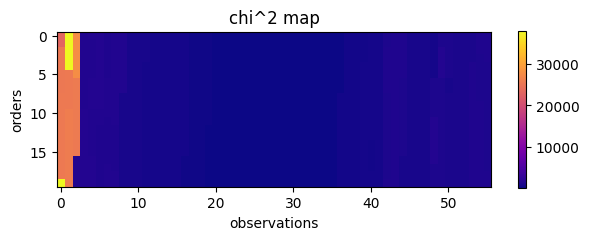

In [48]:
chisq = results['chisq'].reshape((56, 20))
plt.figure(figsize=(6,2))
plt.imshow(chisq.T, cmap='plasma')
plt.colorbar()
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("chi^2 map")

Text(0.5, 1.0, 'vsini map')

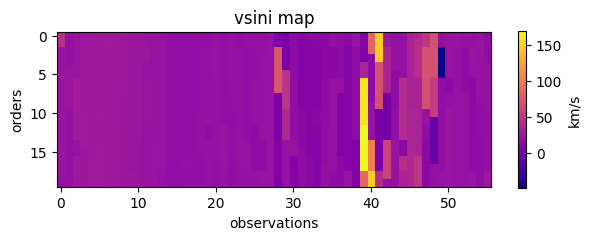

In [49]:
vsini = results['vsini'].reshape((56, 20))
plt.figure(figsize=(6,2))
plt.imshow(vsini.T, cmap='plasma')
plt.colorbar().set_label("km/s")
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("vsini map")

Text(0.5, 1.0, 'rv map')

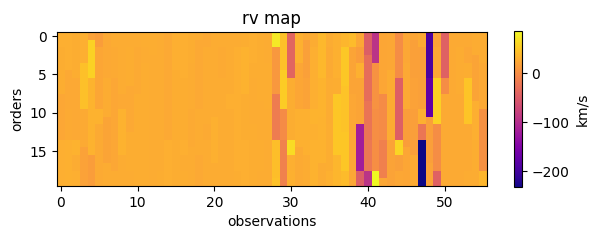

In [50]:
rv = results['rv'].reshape((56, 20)) * 2.99e5
plt.figure(figsize=(6,2))
plt.imshow(rv.T, cmap='plasma')
plt.colorbar().set_label("km/s")
plt.tight_layout()
plt.xlabel("observations")
plt.ylabel("orders")
plt.title("rv map")

#### Plot chi^2 vs params

In [136]:
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
modellist = []
for f in sorted(glob.glob("result/IGRINS_W1049B_H_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    #chipmods[modelname] = np.median(chipmods[modelname], axis=0) # avg over 56 obs
    modellist.append(modelname)
for f in sorted(glob.glob("result/IGRINS_W1049B_H_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
    #chiplams[modelname] = np.median(chiplams[modelname], axis=0) # avg over 56 obs
for f in sorted(glob.glob("result/IGRINS_W1049B_H_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']

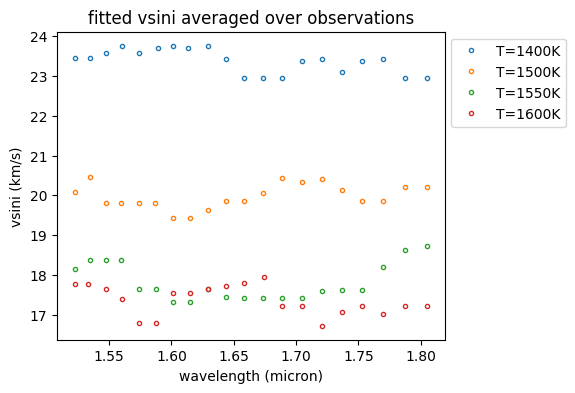

In [137]:
plt.figure(figsize=(5,4))
for model in modellist:

    lam_points = np.median(chiplams[model], axis=2).flatten() # plot all points
    vsini_points = vsini[model].flatten() # plot all points

    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    vsini_points = np.median(vsini[model].reshape((56, 20)), axis=0)

    plt.plot(lam_points, vsini_points, ".", mfc="none", label=f"T={float(model[4:8])*100:.0f}K")
    plt.xlabel("wavelength (micron)")
    plt.ylabel("vsini (km/s)")
    plt.legend(bbox_to_anchor=(1, 1))

    plt.title("fitted vsini for each observation")
    plt.title("fitted vsini averaged over observations")

#plt.ylim(10,60)

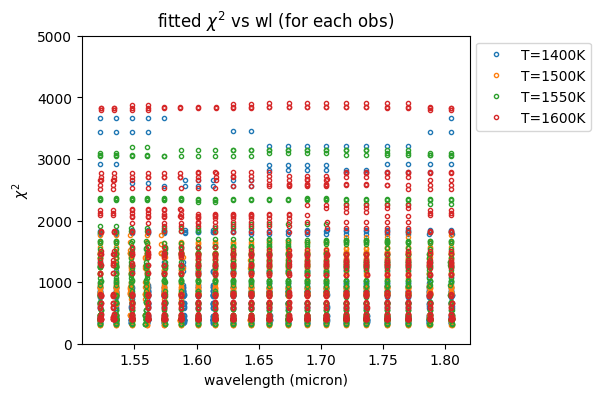

In [138]:
plt.figure(figsize=(5,4))
for model in modellist:
    chisq_points = chisq[model] # plot all points
    lam_points = np.median(chiplams[model], axis=2).flatten() # plot all points
    #chisq_points = np.median(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
    #lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    plt.plot(lam_points, chisq_points, ".", mfc="none", label=f"T={float(model[4:8])*100:.0f}K")
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("fitted $\chi^2$ vs wl (for each obs)")
    #plt.title("fitted $\chi^2$ vs wl (median over obs)") # plot one point per wl
    plt.legend(bbox_to_anchor=(1, 1))
    #plt.xlim((1.5, 1.8))
    plt.ylim((0,5000))

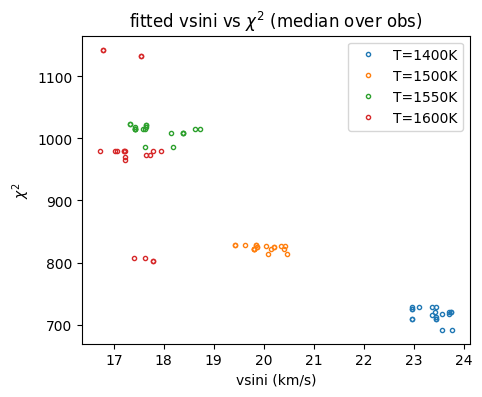

In [140]:
plt.figure(figsize=(5,4))
for model in modellist:
    chisq_points = chisq[model] # plot all points
    vsini_points = vsini[model] # plot all points
    chisq_points = np.median(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
    vsini_points = np.median(vsini[model].reshape((56, 20)), axis=0) # plot one point per wl
    plt.plot(vsini_points, chisq_points, ".", mfc="none", label=f"T={float(model[4:8])*100:.0f}K")
    plt.xlabel("vsini (km/s)")
    plt.ylabel("$\chi^2$")
    plt.title("fitted vsini vs $\chi^2$ (for each obs)")
    #plt.ylim((0,3000))
    #plt.xlim((0,100))
    plt.title("fitted vsini vs $\chi^2$ (median over obs)") # plot one point per wl
    plt.legend(bbox_to_anchor=(1, 1))

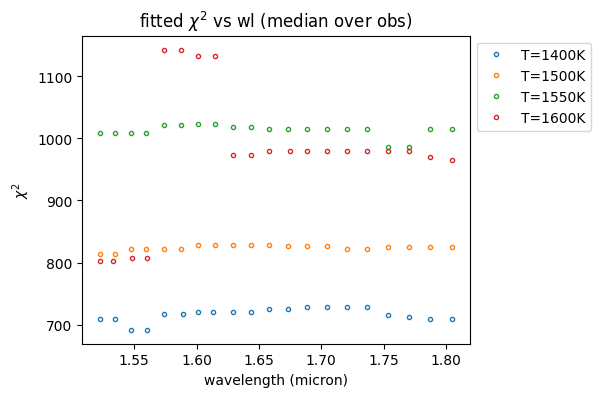

In [142]:
plt.figure(figsize=(5,4))
for model in modellist:
    chisq_points = chisq[model] # plot all points
    lam_points = np.median(chiplams[model], axis=2).flatten() # plot all points
    chisq_points = np.median(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    plt.plot(lam_points, chisq_points, ".", mfc="none", label=f"T={float(model[4:8])*100:.0f}K")
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("fitted $\chi^2$ vs wl (for each obs)")
    plt.title("fitted $\chi^2$ vs wl (median over obs)") # plot one point per wl
    plt.legend(bbox_to_anchor=(1, 1))

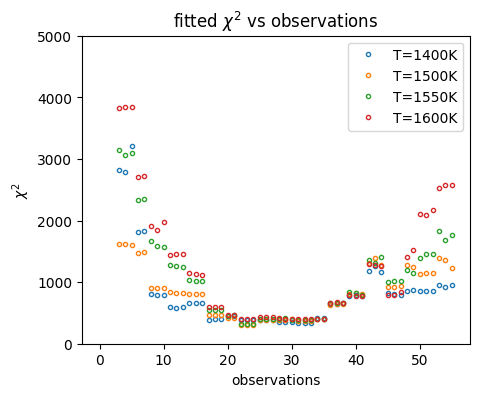

In [141]:
plt.figure(figsize=(5,4))
for model in modellist:
    chisq_points = np.median(chisq[model].reshape((56, 20)), axis=1) # plot one point per obs
    obs_points = np.arange(56) # plot one point per order
    plt.plot(obs_points, chisq_points, ".", mfc="none", label=f"T={float(model[4:8])*100:.0f}K")
    plt.xlabel("observations")
    plt.ylabel("$\chi^2$")
    plt.title("fitted $\chi^2$ vs observations")
    #plt.title("fitted $\chi^2$ vs wl (median over obs)") # plot one point per wl
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylim((0,5000))

fmin: [414.79938264 414.79938264 414.79938264 414.79938264 414.79938264
 414.79938264 414.39905636 414.39905636 305.91465739 305.91465739
 305.66024797 305.66024797 305.66024797 305.66024797 305.66024797
 305.66024797 305.76106008 305.76106008 305.76106008 305.76106008]


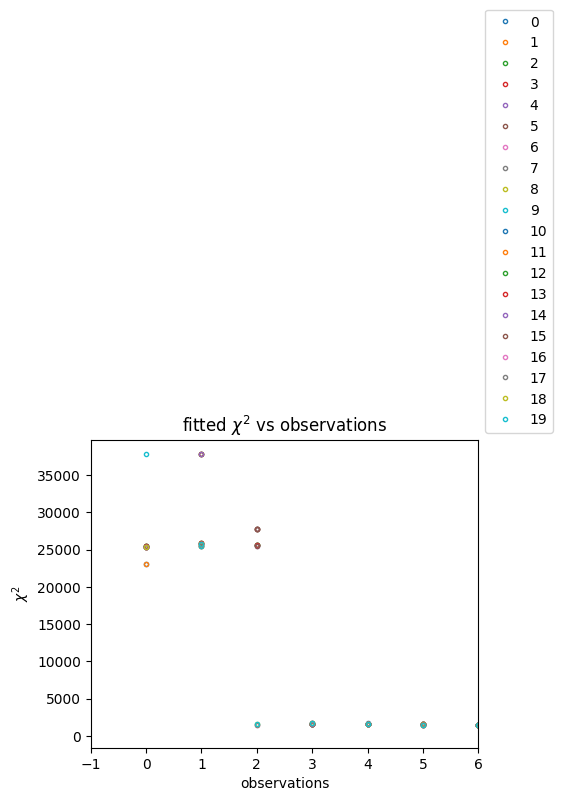

In [114]:
plt.figure(figsize=(5,4))
for model in ['lte015.0-5.0']:
    chisq_points = chisq[model].reshape((56, 20)) # plot one point per obs
    obs_points = np.arange(56) # plot one point per order
    for order in range(20):
        plt.plot(obs_points, chisq_points[:,order], ".", mfc="none", label=order)
    plt.xlabel("observations")
    plt.ylabel("$\chi^2$")
    plt.title("fitted $\chi^2$ vs observations")
    #plt.title("fitted $\chi^2$ vs wl (median over obs)") # plot one point per wl
    plt.legend(bbox_to_anchor=(1, 1))
    #plt.ylim((0,2000))
    plt.xlim((-1,6))
print("fmin:", chisq_points[22])

(0.5, 1.5)

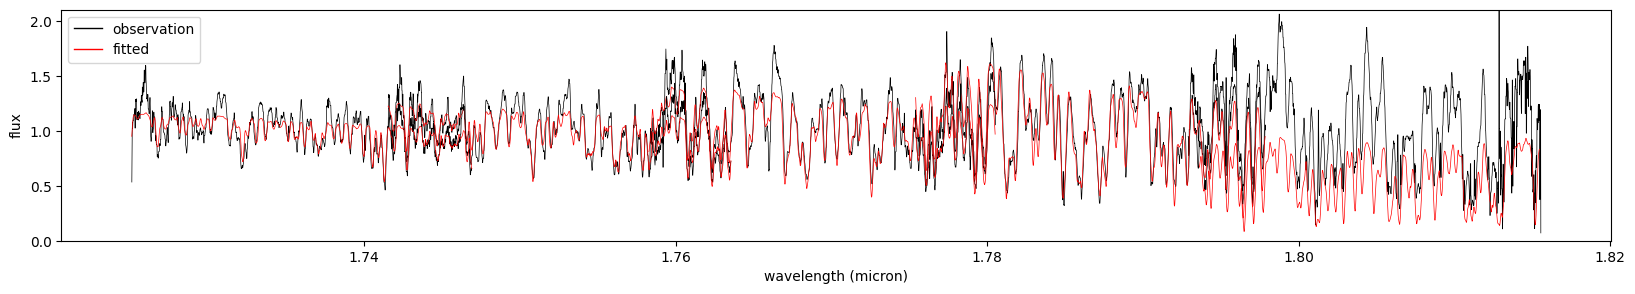

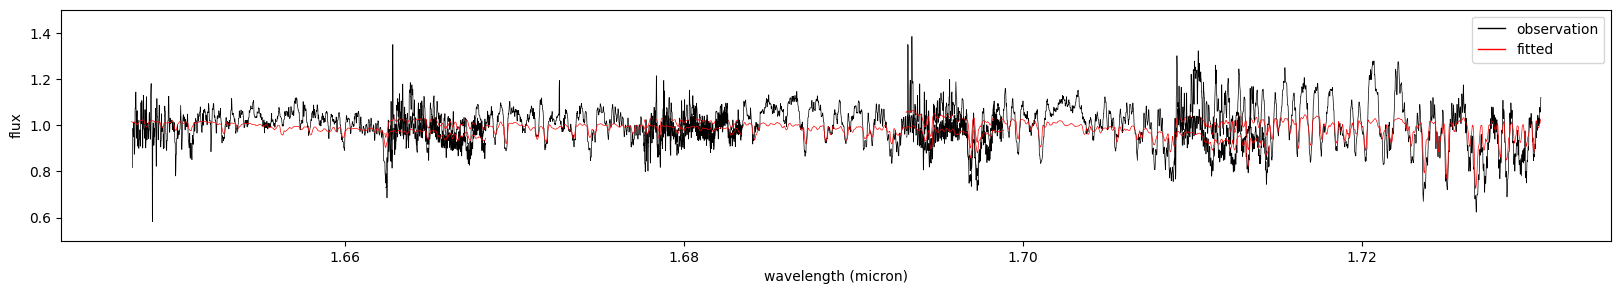

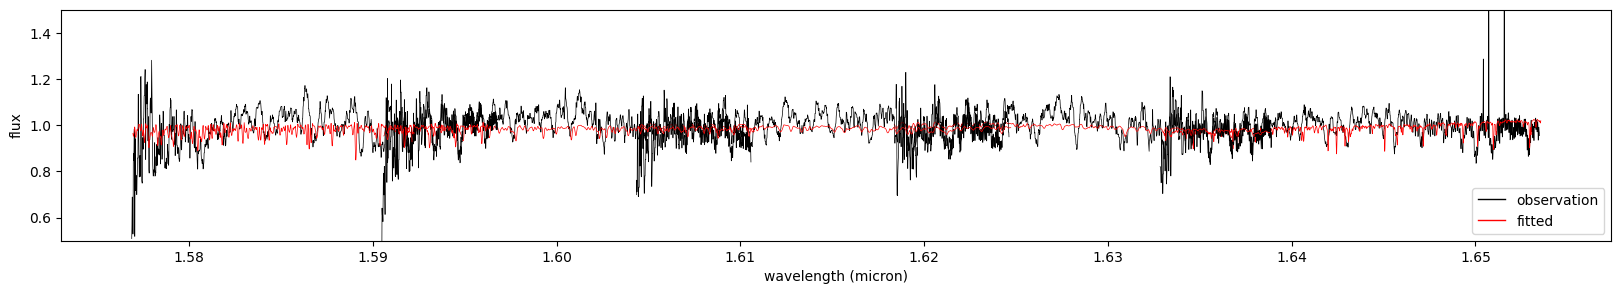

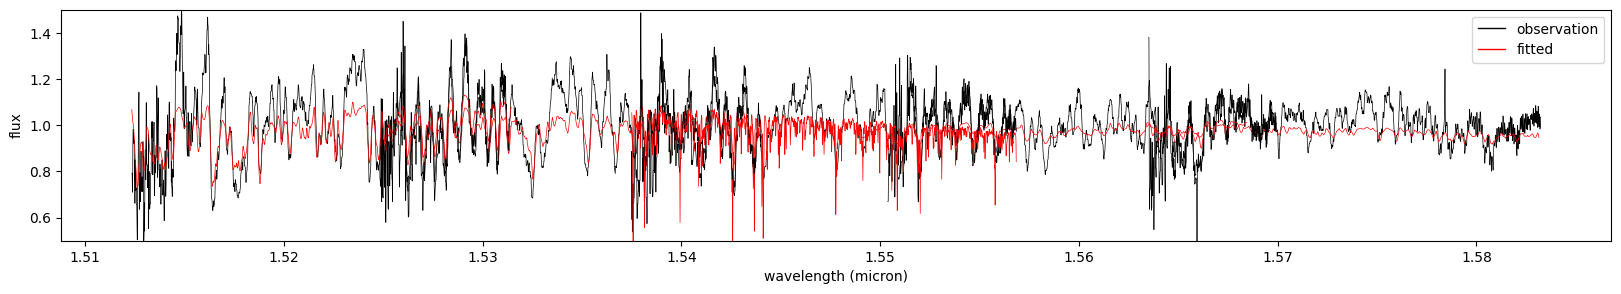

In [104]:
model = 'lte015.0-5.0'
obs = 23
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,3))
for jj in range(5):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, color="r", label="fitted")
    #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="r", lw=1),]
                #Line2D([0], [0], color="g", lw=1),]
plt.legend(custom_lines, ["observation", "fitted"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0, 2.1))

plt.figure(figsize=(20,3))
for jj in range(5,10):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, color="r", label="fitted")
    #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="r", lw=1),]
                #Line2D([0], [0], color="g", lw=1),]
plt.legend(custom_lines, ["observation", "fitted"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0.5, 1.5))

plt.figure(figsize=(20,3))
for jj in range(10,15):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, color="r", label="fitted")
    #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="r", lw=1),]
                #Line2D([0], [0], color="g", lw=1),]
plt.legend(custom_lines, ["observation", "fitted"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0.5, 1.5))

plt.figure(figsize=(20,3))
for jj in range(15,20):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, color="r", label="fitted")
    #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="r", lw=1),]
                #Line2D([0], [0], color="g", lw=1),]
plt.legend(custom_lines, ["observation", "fitted"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0.5, 1.5))

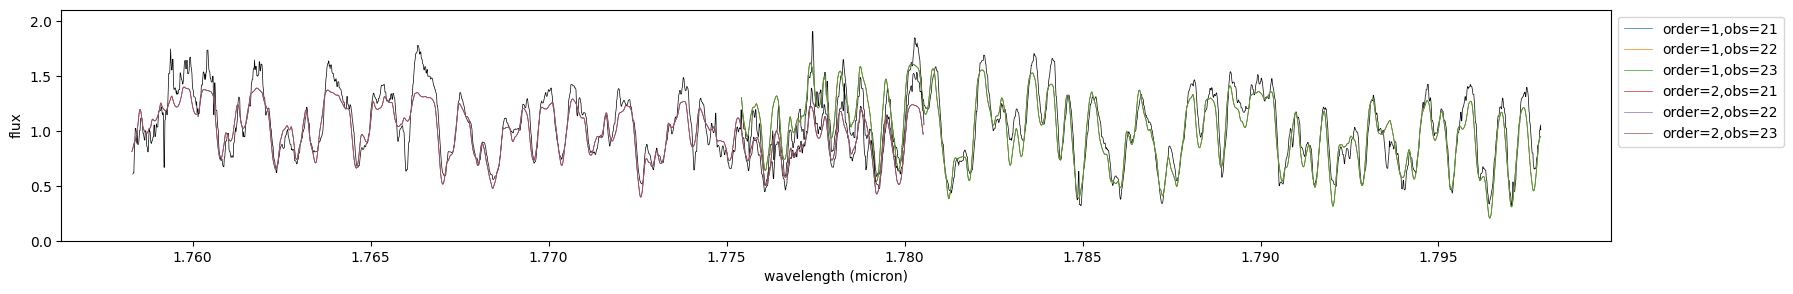

In [135]:
model = 'lte015.0-5.0'
obs = 23
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,3))
for jj in range(1,3):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black")
    for obs in range(21,24):
        plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, label=f"order={jj},obs={obs}")

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0, 2.1))
chi2 = np.array(chisq[model].reshape((56, 20)))

Text(0.5, 1.0, 'fitted $\\chi^2$ at order 1')

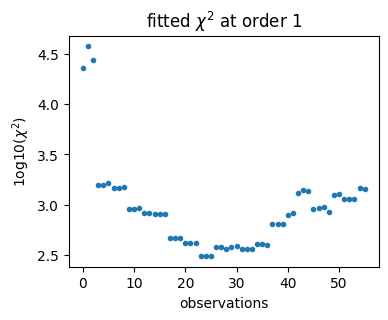

In [128]:
plt.figure(figsize=(4,3))
plt.plot(np.log10(chi2[:,1]), ".")
plt.ylabel("1og10($\chi^2$)")
plt.xlabel("observations")
plt.title("fitted $\chi^2$ at order 1")